In [2]:
import time
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow import keras
from keras import backend as K

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

Use tf.data to batch and shuffle the data

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

train_size = 60000
batch_size = 32
test_size = 10000

train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))


2023-03-19 00:22:27.959146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38278 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-03-19 00:22:27.960941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38278 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:44:00.0, compute capability: 8.0
2023-03-19 00:22:27.962448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38278 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:84:00.0, compute capability: 8.0
2023-03-19 00:22:27.964019: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38278 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two s ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
In the encoder network there are a total of four Conv blocks each consisting of a `Conv2D`, `BatchNorm` and `LeakyReLU` activation function. In each block, the image is downsampled by a factor of two. The slope of `LeakyReLU` is by default 0.2.

In the final block or the Flatten layer we convert the `[None, 7, 7, 64]` to a vector of size 3136.

The decoder network of the variational autoencoder is exactly similar to a vanilla autoencoder. It takes an input of size `[None, 2]`. The initial block has a `Dense` layer having 3136 neurons, recall in the encoder function this was the size of the vector after flattening the output from the last conv block. There are a total of four Conv blocks. The Conv block `[1, 3]` consists of a `Conv2DTranspose`, `BatchNorm` and `LeakyReLU` activation function. The Conv block 4 has a `Conv2DTranspose` with sigmoid activation function, which squashes the output in the range `[0, 1]` since the images are normalized in that range. In each block, the image is upsampled by a factor of two.

The output from the decoder network is a tensor of size `[None, 28, 28, 1]`.
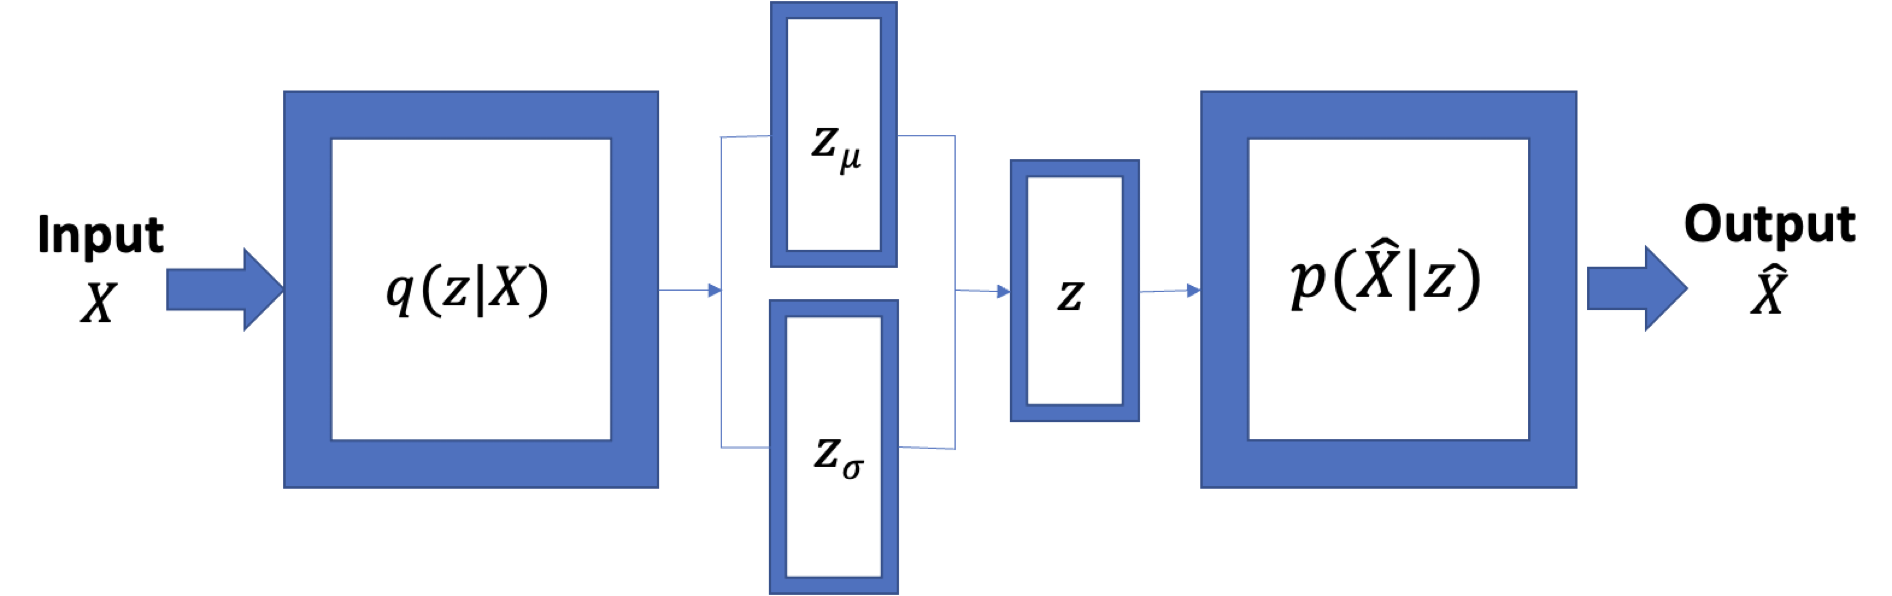

In [4]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        self.latent_dim=latent_dim
        self.encoder = tf.keras.Sequential(
    
    [
    tf.keras.layers.InputLayer(input_shape=(28,28,1), name='input_layer'),
    
    # Block-1
    tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1'),
    tf.keras.layers.BatchNormalization(name='bn_1'),
    tf.keras.layers.LeakyReLU(name='lrelu_1'),
    
     
    # Block-2
    tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2'),
    tf.keras.layers.BatchNormalization(name='bn_2'),
    tf.keras.layers.LeakyReLU(name='lrelu_2'),
     
    # Block-3
    tf.keras.layers.Conv2D(64, 3, 2, padding='same', name='conv_3'),
    tf.keras.layers.BatchNormalization(name='bn_3'),
    tf.keras.layers.LeakyReLU(name='lrelu_3'),

   
    # Block-4
    tf.keras.layers.Conv2D(64, 3, 1, padding='same', name='conv_4'),
    tf.keras.layers.BatchNormalization(name='bn_4'),
    tf.keras.layers.LeakyReLU(name='lrelu_4'),    

    # Final Block
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(latent_dim+latent_dim, name='mean')
    ]
    )

        self.decoder= tf.keras.Sequential(
          [

    tf.keras.layers.InputLayer(input_shape=(latent_dim,), name='input_layer'),
    tf.keras.layers.Dense(3136, name='dense_1'),
    tf.keras.layers.Reshape((7, 7, 64), name='Reshape_Layer'),
    
    # Block-1
     tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1'),
     tf.keras.layers.BatchNormalization(name='bn_1'),
     tf.keras.layers.LeakyReLU(name='lrelu_1'),
   
    # Block-2
     tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2'),
     tf.keras.layers.BatchNormalization(name='bn_2'),
     tf.keras.layers.LeakyReLU(name='lrelu_2'),
     
    # Block-3
     tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3'),
     tf.keras.layers.BatchNormalization(name='bn_3'),
     tf.keras.layers.LeakyReLU(name='lrelu_3'),
     
    # Block-4
     tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')
          ]
     )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    




### Objective Function of VAE

VAE’s loss function comprises a Reconstruction error, and a $KL$-divergence error used to model the networks’ objectives. The final loss is a weighted sum of both losses.

VAE’s total loss can be given as:

$L=(reconstruction\ loss)+(regularization\ term)$

$L=\frac1N\sum_{i=1}^N(X_i-\hat{X}_i)^2+KL(q(z|X)||N(0,1))$, where $X_i$s are input images, $\hat{X}_i$ are the reconstructed images

$KL(q(z|X)||N(0,1))=-\frac12\sum(1+\log z^2_{\sigma_i}-z^2_{\mu_i}-z^2_{\sigma_i})$

### Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$
* Note: Since you use the dataset loaded by keras with 60k datapoints in the training set and 10k datapoints in the test set, our resulting ELBO on the test set is slightly higher than reported results in the literature which uses dynamic binarization of Larochelle's MNIST.

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
 
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss
 
def kl_loss(mean, log_var):
    kl_loss_val =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_val
 
def vae_loss(y_true, y_pred, mean, log_var):
    r_loss = mse_loss(y_true, y_pred)
    kl_loss_val = kl_loss(mean, log_var)
    #print(K.print_tensor(r_loss)," loss")
    return  r_loss + kl_loss_val

def compute_loss(model,images):
        
    mean,log_var= model.encode(images)
    latent=model.reparameterize(mean,log_var)
    generated_images = model.decoder(latent)
    loss = vae_loss(images, generated_images, mean, log_var)
  
    return tf.reduce_mean(loss)


  

def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In the training loop we first pass the image to the encoder, then the latent variables mean and variance are fed to the sampling model and the output latent is finally fed to the decoder. The loss is computed over the images generated by the decoder.

Next, we compute the gradients and update the encoder & decoder parameters using the Adam optimizer. Finally, we return the loss.

In [6]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images,model,optimizer):

    with tf.GradientTape() as tape:
        
        #mean,log_var= model.encode(images)
        #mean, log_var = tf.split(enc(images,training=True), num_or_size_splits=2, axis=1)
        #print(" IS IT HERE???")
        #latent = sampling(mean, log_var)
        #latent=model.reparameterize(mean,log_var)
        #generated_images = model.decoder(latent)
        #loss = vae_loss(images, generated_images, mean, log_var)

        loss=compute_loss(model,images)
 
    

    gradients = tape.gradient(loss, model.trainable_variables)
     
     
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

Finally, we train our Autoencoder model. The train function below takes the train_dataset, epochs,model, optimizer and test_sample as the parameters and calls the train_step function at every new batch a number of times.

At every epoch it displays a generated image from the last training epoch using the test sample defined beforehand

2023-03-19 00:22:33.082896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-19 00:22:37.826536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


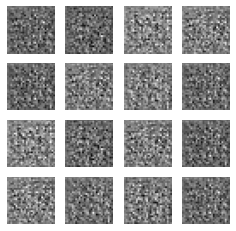

2023-03-19 00:22:42.804346: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x14f9a623a690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-19 00:22:42.804415: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-03-19 00:22:42.804422: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-03-19 00:22:42.804426: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-03-19 00:22:42.804430: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-03-19 00:22:42.810977: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-19

tf.Tensor(78.456955, shape=(), dtype=float32)  loss
Time for epoch 1 is 13.19700002670288 sec


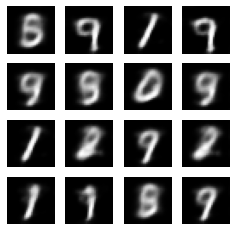

tf.Tensor(70.379974, shape=(), dtype=float32)  loss
Time for epoch 2 is 7.615238904953003 sec


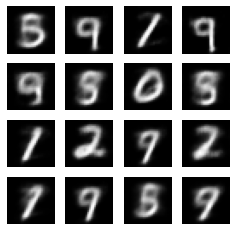

tf.Tensor(64.51782, shape=(), dtype=float32)  loss
Time for epoch 3 is 7.625014305114746 sec


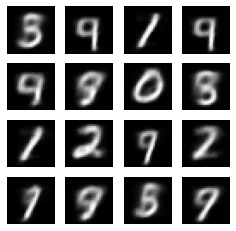

tf.Tensor(64.59459, shape=(), dtype=float32)  loss
Time for epoch 4 is 7.614827871322632 sec


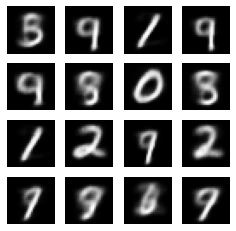

tf.Tensor(60.570564, shape=(), dtype=float32)  loss
Time for epoch 5 is 7.616778373718262 sec


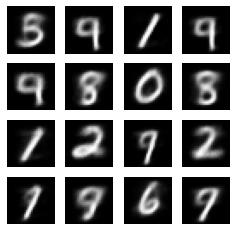

tf.Tensor(68.53899, shape=(), dtype=float32)  loss
Time for epoch 6 is 7.617513656616211 sec


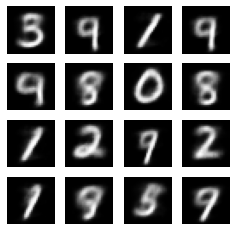

tf.Tensor(62.71642, shape=(), dtype=float32)  loss
Time for epoch 7 is 7.619215250015259 sec


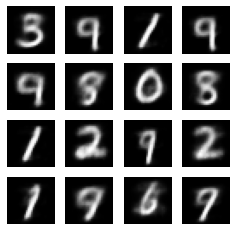

tf.Tensor(64.95769, shape=(), dtype=float32)  loss
Time for epoch 8 is 7.629238128662109 sec


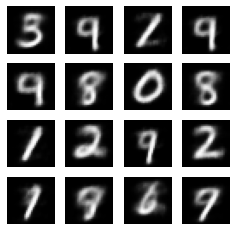

tf.Tensor(67.532776, shape=(), dtype=float32)  loss
Time for epoch 9 is 7.619526624679565 sec


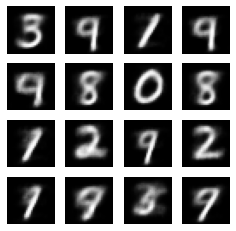

tf.Tensor(64.788574, shape=(), dtype=float32)  loss
Time for epoch 10 is 7.643623113632202 sec


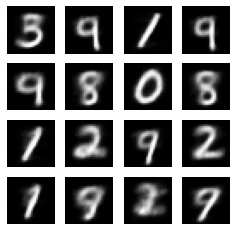

tf.Tensor(60.36616, shape=(), dtype=float32)  loss
Time for epoch 11 is 7.639585971832275 sec


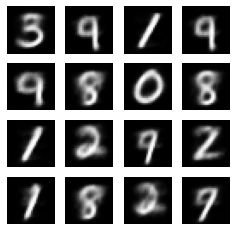

tf.Tensor(56.706596, shape=(), dtype=float32)  loss
Time for epoch 12 is 7.637815713882446 sec


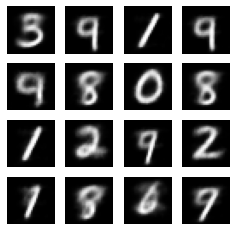

tf.Tensor(64.582245, shape=(), dtype=float32)  loss
Time for epoch 13 is 7.6134984493255615 sec


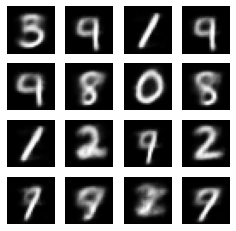

In [ ]:
def train(dataset, epochs,model,optimizer,test_sample):
    generate_and_save_images(model, 0, test_sample)
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
      
            l=train_step(image_batch,model,optimizer)
      
        print(l," loss")
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  
        generate_and_save_images(model, 0, test_sample)

num_examples_to_generate = 16

assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]



model=CVAE(2)



train(train_dataset, 30,model,optimizer,test_sample)


generate_and_save_images(model, 0, test_sample)